In [1]:
# Generate LDA histograms and reconstructions

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdges
Mon Jun 27 13:07:27 PDT 2022


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from sklearn.decomposition import PCA
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
config = general.load_config_file(path_config)
control = controller.Controller(config)
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
# local_staging_variance_edges is generated by using the output dataframe from the
# mapping process to filter out not matched cells from the full dataset.
dsname = "edges"
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    dsname: {
        "control": f"{path_cvapipe}/local_staging_variance_edges",
        "perturbed": f"{path_cvapipe}/local_staging_edge_cells_midpoint_expanded"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)
df_map = smapper.result
df_map.head()

	edges loaded. (5169, 1255)


NUC_MEM_PC1  NUC_MEM_PC2  NUC_MEM_PC3  \
dataset structure_name CellId                                          
base    AAVS1          466245    -0.268392    -0.829342     0.047623   
                       466246    -0.243572    -0.607768     0.631536   
                       466248    -0.402700    -0.944572    -0.832112   
                       466252     0.204445     0.848568     0.504295   
                       466254    -0.560492     0.529491     0.330510   

                               NUC_MEM_PC4  NUC_MEM_PC5  NUC_MEM_PC6  \
dataset structure_name CellId                                          
base    AAVS1          466245     1.605686     2.121168     4.532400   
                       466246     0.183432    -0.023279     0.018518   
                       466248    -0.943582     1.107919     0.192332   
                       466252     1.485295     1.869869    -1.348347   
                       466254    -0.276561    -0.058453    -0.889612   

                               NUC_MEM_PC7  NUC_MEM_PC8  Dist  SelfDist  \
dataset structure_name CellId                                             
base    AAVS1          466245    -1.457944    -1.057527   NaN       NaN   
                       466246    -0.563475     0.252779   NaN       NaN   
                       466248     1.015603     2.536070   NaN       NaN   
                       466252    -0.242527     0.776847   NaN       NaN   
                       466254     1.469526    -0.531870   NaN       NaN   

                               NNCellId  Match  edges  
dataset structure_name CellId                          
base    AAVS1          466245        -1  False  False  
                       466246        -1  False  False  
                       466248        -1  False   True  
                       466252        -1  False  False  
                       466254        -1  False  False

### Loading and voxelizing matched shape

In [8]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{inner_alias}_matched.vtk"
inner_mesh = device.read_vtk_polydata(fname)
outer_alias = control.get_outer_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{outer_alias}_matched.vtk"
outer_mesh = device.read_vtk_polydata(fname)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [9]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

### Control and Device for each shape matched dataset (control and perturbed)

In [10]:
importlib.reload(io)
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdges/../tools/common.py'>

In [11]:
dsmanagers = common.setup_cvapipe_for_matched_dataset(config, datasets[dsname])

### Load representations and compute PCA

In [12]:
gene = "TOMM20"
namemap = {"control": "base", "perturbed": dsname}

In [13]:
df_gene = df_map.loc[(dsname,gene)]

CellIds_pt = df_gene.index.values
CellIds_ct = df_gene.NNCellId.unique()

rloader_ct = common.RepsSharedMemoryLoader(dsmanagers["control"]["control"])
rloader_pt = common.RepsSharedMemoryLoader(dsmanagers["perturbed"]["control"])
reps_ct = rloader_ct.load(CellIds_ct).astype(np.uint8)
reps_pt = rloader_pt.load(CellIds_pt).astype(np.uint8)

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

In [14]:
# df_gene = df_map.loc[(dsname,gene)]

# CellIds_pt = df_gene.index.values[:10]
# CellIds_ct = df_gene.NNCellId.unique()[:10]

# CellIds_ct, reps_ct = common.get_all_parameterized_intensity_of_seg_channel(CellIds_ct, dsmanagers["control"]["device"])
# CellIds_pt, reps_pt = common.get_all_parameterized_intensity_of_seg_channel(CellIds_pt, dsmanagers["perturbed"]["device"])

# print(reps_ct.max(), reps_ct.sum(), reps_pt.sum())

# # rloader_ct = common.RepsSharedMemoryLoader(dsmanagers["control"]["control"])
# # rloader_pt = common.RepsSharedMemoryLoader(dsmanagers["perturbed"]["control"])
# # reps_ct = rloader_ct.load(CellIds_ct)
# # reps_pt = rloader_pt.load(CellIds_pt)

In [15]:
reps = np.concatenate([reps_ct, reps_pt], axis=0)
vsize = int(sys.getsizeof(reps)) / float(1 << 20)
print(f"Data shape: {reps.shape} ({reps.dtype}, {vsize:.1f}Mb)")

Data shape: (622, 532610) (uint8, 315.9Mb)


In [16]:
npcs = np.min([32, reps.shape[0]-1])
pca = PCA(npcs, svd_solver="full")
pca = pca.fit(reps)
axes = pca.transform(reps)
axes = pd.DataFrame(axes, columns=[f"PC{i}" for i in range(1, 1+npcs)])

In [17]:
groups = np.array([0]*len(CellIds_ct) + [1]*len(CellIds_pt))
stds = axes.std(axis=0)
axes /= stds
axes, pca = common.sort_pcs(axes, groups, pca)
axes["Dataset"] = groups
axes["CellId"] = CellIds_ct.tolist() + CellIds_pt.tolist()
axes = axes.set_index(["Dataset", "CellId"])
axes.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
Dataset CellId                                                               
0       272786  0.621357 -1.008935 -0.216103 -0.706953  1.770741 -1.283134   
        275533 -0.918536 -0.172421  0.085092  0.555411  0.095599  0.686038   
        915534 -0.475863 -0.351405  0.904547  0.133952  0.986491 -0.598003   
        922901 -0.452581 -0.751481 -0.611373 -0.933470 -1.230951  0.754946   
        348606  0.520303 -1.149214 -1.287957 -1.121377 -1.368694  0.672067   

                     PC7       PC8       PC9      PC10  ...      PC23  \
Dataset CellId                                          ...             
0       272786  0.764853 -0.453189  1.751740 -1.742828  ...  0.571368   
        275533 -0.116022 -0.569162  0.231346 -1.240830  ... -0.187029   
        915534  0.076387 -0.652094 -1.181397 -1.257514  ... -1.318510   
        922901 -0.233813  0.023091 -1.441995  0.197209  ... -0.213857   
        348606  0.134461 -0.059613  0.650088 -0.974527  ...  0.121377   

                    PC24      PC25      PC26      PC27      PC28      PC29  \
Dataset CellId                                                               
0       272786 -0.905825  1.995865  0.145878 -0.589751  0.184080 -1.290924   
        275533  0.601404 -0.934548  1.662591  0.057802  0.688510 -0.486437   
        915534  0.660936 -0.438405 -1.164128  0.227478  0.007805  0.801424   
        922901 -0.704164 -0.912250 -0.581804  0.193107 -0.594265  0.150031   
        348606 -0.115932 -0.096428  0.385897  1.008067 -0.382914 -0.236631   

                    PC30      PC31      PC32  
Dataset CellId                                
0       272786  0.368933  1.365964 -0.575190  
        275533  1.091232  0.032769  0.154714  
        915534  0.554272 -1.379471  0.123496  
        922901 -0.434631 -0.354581 -0.298349  
        348606 -1.088169 -0.281516 -0.476207  

[5 rows x 32 columns]

### Compute LDA

In [18]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureEdges/../tools/common.py'>

In [19]:
lda = common.SimpleBinaryLDA()
lda = lda.sfit(axes.values, groups)
lda_values = lda.transform(axes.values).flatten()
axes["LDA"] = lda_values

0 -0.525615
1 0.48656


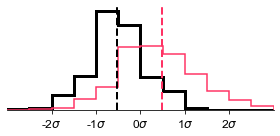

In [40]:
xmin, xmax = -3, 3
edges = np.linspace(xmin, xmax, 1+int((xmax-xmin)/0.5))
fig, ax = plt.subplots(1,1, figsize=(4.0, 2))
for color, (g, df_group) in zip(["black","#FF3264"], axes.groupby("Dataset")):
    lw = 3 if g == 0 else 1.5
    ax.hist(df_group.LDA, bins=edges, histtype="step", color=color, density=True, lw=lw)
    ax.axvline(x=df_group.LDA.mean(), color=color, lw=2, linestyle="--", zorder=1e10)
    print(g, df_group.LDA.mean())
ax.set_xlim(xmin, xmax)
for pos in ["top", "right", "left"]:
    ax.spines[pos].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sigmas = np.linspace(-2, 2, 5)
ax.set_xticks(sigmas, [f"{int(s)}$\sigma$" for s in sigmas])
ax.tick_params(axis="x", which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f"FigureEdges3_{gene}_lda_hist.pdf")
plt.show()

In [21]:
mps = [-2,-1,0,1,2]
pcs_back = lda.walk(mps)#, limit_to_range=lda_values, return_map_points=True)
pcs_back *= stds.values
pcs_back = pd.DataFrame(pcs_back, columns=[f"PC{i}" for i in range(1,1+npcs)])
reps_back = pca.inverse_transform(pcs_back).reshape(len(mps), 65, -1)

In [22]:
instances = []
for rep in tqdm(reps_back):
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=rep
    )
#     morphed -= morphed.min() #shift to make min val = 0
    instances.append(np.stack([domain_nuc, domain_mem, morphed], axis=0))

  0%|          | 0/5 [00:00<?, ?it/s]

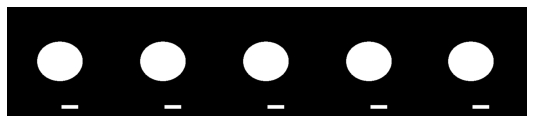

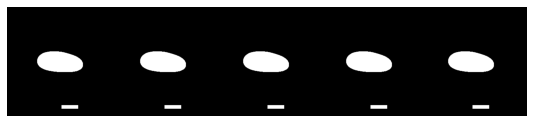

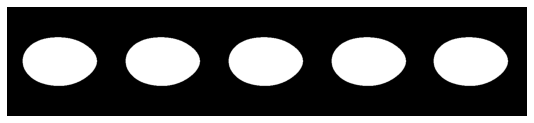

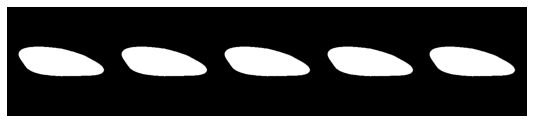

In [23]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.3}, "sharex": True, "sharey": True}
for alias in ["nuc", "mem"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(mps), figsize=(2*len(mps), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
        plt.savefig(f"FigureEdges3_{gene}_lda_{alias}_{orient}.png", dpi=150)
        plt.show()

In [24]:
# Percentil relative to center
contrast = common.Projector.get_shared_morphed_max_based_on_pct_for_zy_views(
    instances = instances,
    pct = 90,
    mode = mode,
    func = np.mean
)

In [25]:
orients = ["z", "y"]
vmin, vmax = 0, np.nanmax([contrast[ax][1] for ax in orients])
print(gene, vmin, vmax)

TOMM20 0 0.19601090401411056


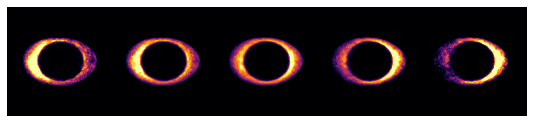

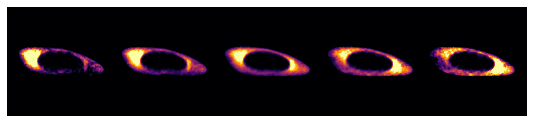

In [26]:
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.3}, "sharex": True, "sharey": True}
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(mps), figsize=(2*len(mps), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance)
        proj.set_gfp_colormap("inferno")
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_projection_mode(ax=orient, mode=mode)
        view = proj.project_on(alias="gfp", ax=ax)
    plt.savefig(f"FigureEdges3_{gene}_lda_gfp_{orient}.png", dpi=150)
    plt.show()

### Reconstruct chosen instances along LDA

In [27]:
dfs = {}
for condition, manager in dsmanagers.items():
    dfs[condition] = manager["device"].load_step_manifest("preprocessing")
    print(condition, dfs[condition].shape)

control (4477, 1290)
perturbed (5169, 1255)


In [28]:
# Ids from the gene being analyzed
representative_ids = {
    "TOMM20": [350008, 324609, 321239, 973641, 267287, 929060],
    "ACTN": [572411, 541232, 577227,560334, 635240, 556067]
}

In [29]:
instances = []
for CellId in tqdm(representative_ids[gene]):
    _, ds = axes.index.get_loc_level(CellId, "CellId")
    # Control=0, Perturbed=1
    condition = "control" if ds[0]==0 else "perturbed"
    control_cond = dsmanagers[condition]["control"]
    print(CellId, condition, f"{axes.at[(ds[0],CellId),'LDA']:.2f}")
    row = dfs[condition].loc[CellId].copy()
    if condition == "control":
        row.crop_seg = row.crop_seg.replace("projects/cvapipe_analysis/local_staging_variance_edges", "datasets/hpisc_single_cell/variance/local_staging_variance")
        row.crop_seg = row.crop_seg.split("ome")[0]+"ome.tif"
    producer = io.DataProducer(control_cond)
    producer.set_row(row)
    producer.load_single_cell_data()
    producer.align_data(force_alignment=True)
    instances.append(producer.data_aligned[[3, 5, 7]])

  0%|          | 0/6 [00:00<?, ?it/s]

350008 control -1.85
324609 control -0.73
321239 control -0.03
973641 perturbed 0.26
267287 perturbed 0.94
929060 perturbed 1.82


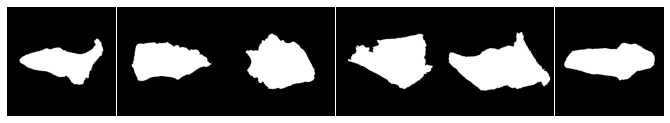

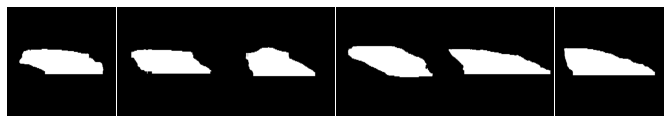

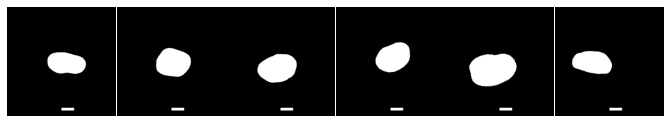

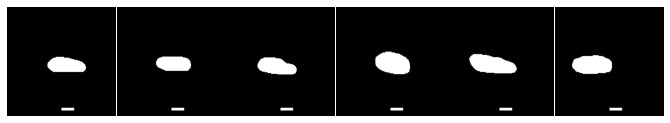

In [30]:
mode = {
    "nuc": "max",
    "mem": "max",
    "gfp": "mean"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for alias in ["mem", "nuc"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=396)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureEdges3_{gene}_inst_{alias}_{orient}.png", dpi=150)
        plt.show()

In [31]:
vmin, vmax = control.get_optimal_seg_contrast(gene)

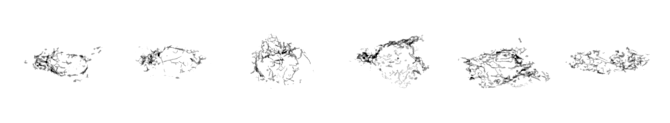

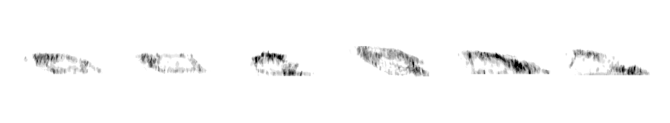

In [32]:
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance, box_size=396)
        proj.set_projection_mode(ax=orient, mode=mode)
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_gfp_colormap("binary")
        view = proj.project_on(alias="gfp", ax=ax)
        plt.savefig(f"FigureEdges3_{gene}_inst_gfp_{orient}.png", dpi=150)
    plt.show()

### Reconstruct morphed version of chosen instances along LDA

In [33]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{inner_alias}_matched.vtk"
inner_mesh = device.read_vtk_polydata(fname)
outer_alias = control.get_outer_most_alias_to_parameterize()
fname = f"avgshape/{dsname}_{outer_alias}_matched.vtk"
outer_mesh = device.read_vtk_polydata(fname)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [34]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

In [35]:
instances = []
for CellId in tqdm(representative_ids[gene]):
    _, ds = axes.index.get_loc_level(CellId, "CellId")
    condition = "control" if ds[0]==0 else "perturbed"
    device_cond = dsmanagers[condition]["device"]
    rep = device_cond.read_parameterized_intensity(CellId)
    
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=rep
    )
    instances.append(np.stack([domain_nuc, domain_mem, morphed], axis=0))

  0%|          | 0/6 [00:00<?, ?it/s]

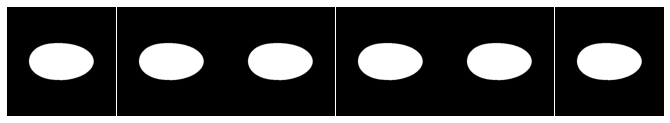

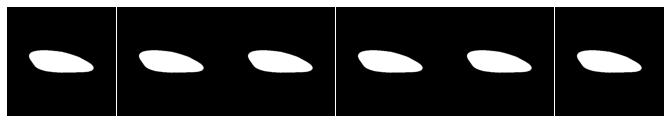

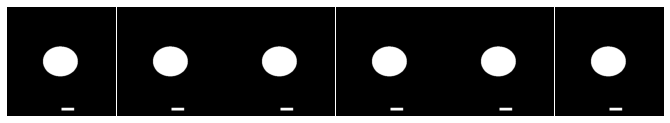

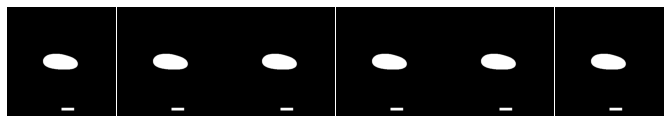

In [36]:
for alias in ["mem", "nuc"]:
    for orient in ["z", "y"]:
        fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
        for ax, instance in zip(axs, instances):
            ax.axis("off")
            proj = common.Projector(instance, box_size=396)
            proj.set_projection_mode(ax=orient, mode=mode)
            view = proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureEdges3_{gene}_morphinst_{alias}_{orient}.png", dpi=150)
        plt.show()

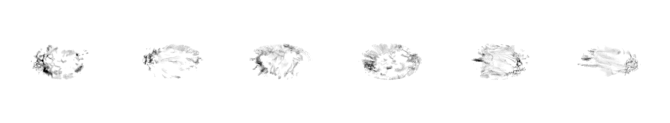

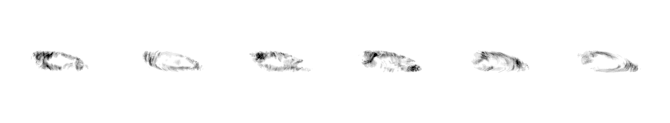

In [37]:
for orient in ["z", "y"]:
    fig, axs = plt.subplots(1,len(instances), figsize=(2*len(instances), 2), **args)
    for ax, instance in zip(axs, instances):
        ax.axis("off")
        proj = common.Projector(instance, box_size=396)
        proj.set_projection_mode(ax=orient, mode=mode)
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_gfp_colormap("binary")
        view = proj.project_on(alias="gfp", ax=ax)
        plt.savefig(f"FigureEdges3_{gene}_morphinst_gfp_{orient}.png", dpi=150)
    plt.show()

In [38]:
common.now("complete")

complete 2022-06-27 13:15:31
